In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))


df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfe, _ = pretrainer.predict(dfcx, batch_size=16)
dfy = df_label.response_label

100%|##########| 71/71 [00:08<00:00,  7.95it/s]


In [3]:
from conceptor.decoder import ProtoNetNFTDecoder

In [4]:
dfg_score, dfc_score = pretrainer.extract(dfcx, batch_size=16)

100%|##########| 71/71 [00:08<00:00,  8.84it/s]


In [99]:
res = []
for dfx_used in [dfg_score[dfg_score.columns.difference(['UEGs'])], 
                 dfc_score[dfc_score.columns.difference(['Reference'])],  
                 df_tpm]:
    
    mode = 'NFT_%s' % len(dfx_used.columns)
    for cohort in tqdm(cohorts, ascii=True):
    
        cohort_idx = df_label[df_label['cohort'] == cohort].index
        cohort_X = dfx_used.loc[cohort_idx]
        cohort_y = dfy.loc[cohort_idx]
    
        test_cohort_name = cohort
    
        predict_res = []
        for train_idx, test_idx in loo.split(cohort_idx):
            
            train_X = cohort_X.iloc[train_idx]
            train_y = cohort_y.iloc[train_idx]
            test_X = cohort_X.iloc[test_idx]    
            test_y = cohort_y.iloc[test_idx]
        
            support_set = train_X.join(train_y)
            query_set = test_X.join(test_y)
            
            NFT = ProtoNetNFTDecoder()
            NFT = NFT.fit(support_set)
            pred_testy = NFT.transform(query_set)
            
            pred_testy['cohort'] = test_cohort_name
            pred_testy['mode'] = mode
            predict_res.append(pred_testy)
    
        df_pred = pd.concat(predict_res)
        dfp = onehot(cohort_y.map({'PD':'NR', 'PR':'R',
                                   'SD':'NR', 'CR':'R',
                                   'NR':'NR', 'R':'R'})).join(df_pred)
    
        y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
        s2 = score2(y_true, y_prob, y_pred)
        
        dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC'], index = ['Test'])
        dfs['cohort'] = test_cohort_name
        dfs['mode'] = mode
        res.append(dfs)

100%|##########| 16/16 [00:47<00:00,  2.98s/it]


In [110]:
df = pd.concat(res)
df.head()

,ROC,PRC,F1,ACC,MCC,cohort,mode
Test,0.282051,0.124695,0.000000,0.437500,-0.372104,Choueiri,NFT_140
Test,0.416667,0.233811,0.181818,0.470588,-0.206584,Miao,NFT_140
Test,0.489796,0.295437,0.500000,0.523810,0.138675,Snyder,NFT_140
Test,0.264706,0.219295,0.285714,0.400000,-0.199098,SU2CLC2,NFT_140
Test,0.512987,0.417143,0.521739,0.560000,0.116131,Zhao,NFT_140


In [111]:
df['mode'].unique()

array(['NFT_140', 'NFT_45', 'NFT_15672'], dtype=object)

In [112]:
mode_dict = {'NFT_140':'Geneset leavel\n(p=140)', 
             'NFT_45':'Cell type/pathway leavel\n(p=45)', 
             'NFT_15672':'Original abundance\n(p=15672)'}

df['mode'] = df['mode'].map(mode_dict)

In [113]:
x_order = df.groupby('mode')['MCC'].mean().sort_values(ascending=False).index

In [114]:
from itertools import combinations
from statannotations.Annotator import Annotator
box_pairs = list(combinations(x_order, 2))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cell type/pathway leavel
(p=45) vs. Geneset leavel
(p=140): t-test paired samples, P_val:2.842e-02 t=2.425e+00
Geneset leavel
(p=140) vs. Original abundance
(p=15672): t-test paired samples, P_val:8.519e-02 t=1.843e+00
Cell type/pathway leavel
(p=45) vs. Original abundance
(p=15672): t-test paired samples, P_val:9.035e-04 t=4.123e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cell type/pathway leavel
(p=45) vs. Geneset leavel
(p=140): t-test paired samples, P_val:2.206e-02 t=2.553e+00
Geneset leavel
(p=140) vs. Original abundance
(p=15672): t-test paired samples, P_val:1.805e-02 t=2.654e+00
Cell type/pathway leavel
(p=45) vs. Original abundance
(p=156

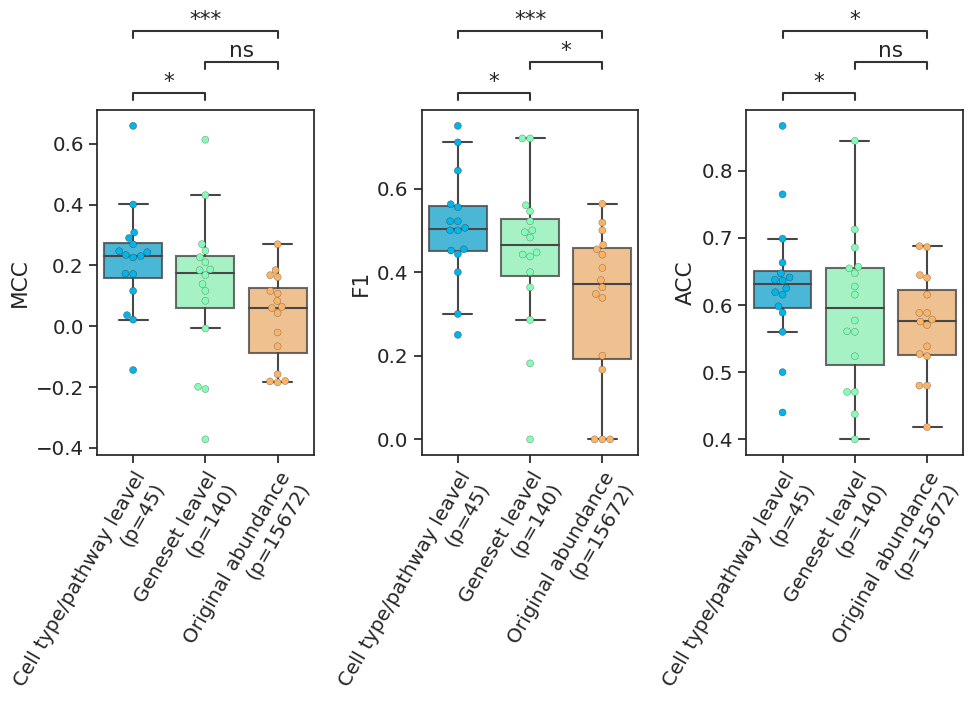

In [117]:
fig,axes = plt.subplots(figsize=(10,8), ncols=3, nrows=1)

(ax1, ax2, ax3) = axes

for ax, y in zip([ax1, ax2, ax3], ['MCC', 'F1', 'ACC',]):
    sns.swarmplot(data = df, x = 'mode', y = y, order = x_order, ax=ax, palette='rainbow', linewidth = 0.3, )
    sns.boxplot(data = df, x = 'mode', y = y, order = x_order, fliersize = 0, ax=ax,
                palette='rainbow',  boxprops={'alpha':0.8})

    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(x_order, 
                        rotation=60, 
                        ha="right",  
                        rotation_mode="anchor")  # <====== HERE is the ke
    ax.set_xlabel('')

    annotator = Annotator(ax, pairs=box_pairs, data=df, x='mode', y=y, order=x_order)
    annotator.configure(test='t-test_paired', text_format='star', loc='outside', comparisons_correction = None,)
    annotator.apply_and_annotate()

fig.tight_layout()
fig.savefig('./Feature_level_impact_in_LOPO.pdf', bbox_inches='tight')
df.to_csv('Source_data_Feature_level_impact_in_LOPO.csv')